In [7]:
import maintsim
import random
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

%xmode verbose

Exception reporting mode: Verbose


In [8]:
sys = maintsim.System(process_times=[3, 5, 4],
                      buffer_sizes=10,
                      failure_mode='degradation',
                      failure_params=[0.25]*3,
                      maintenance_policy='CBM',
                      maintenance_params={'CBM threshold':[6,7,8]},
                      repair_params={'CM':stats.randint(10,20),
                                     'CBM':stats.randint(15,25)},
                      # repair_params={'CM':{'uniform':{'low':10,'high':20)},
                      #                'PM':{'uniform':{'low':5, 'high':10}}},
                      maintenance_capacity=3, debug=True)

In [9]:
sys.simulate(sim_time=100)

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
M0 calling repairman at 11
[] []
11 0 6 False
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
28 2 10 True
[] []
[] []


Interrupt: Interrupt(None)

In [10]:
sys.machine_data[['M{} health'.format(m) for m in range(3)]].ffill()[40:60]

,M0 health,M1 health,M2 health
40,10.0,6.0,10.0
41,10.0,6.0,10.0
42,10.0,6.0,10.0
43,10.0,6.0,10.0
44,10.0,6.0,10.0
45,10.0,6.0,10.0
46,10.0,6.0,10.0
47,10.0,6.0,10.0
48,10.0,6.0,10.0
49,10.0,6.0,10.0


In [10]:
sys.env.now

22

In [33]:
sys = maintsim.System(process_times=[3],
                      buffer_sizes=10,
                      failure_mode='degradation',
                      failure_params=[0.25]*3,
                      maintenance_policy='CBM',
                      maintenance_params={'CBM threshold':[6, 7, 8]},
                      repair_params={'CM':stats.randint(10,20),
                                     'CBM':stats.randint(5,10)},
                      # repair_params={'CM':{'uniform':{'low':10,'high':20)},
                      #                'PM':{'uniform':{'low':5, 'high':10}}},
                      maintenance_capacity=1)

In [36]:
sys.simulate(sim_time=300)

Simulation complete in 0.09s

  Units produced:      23
  System availability: 95.33%



In [37]:
sys.maintenance_data

,time,machine,type,activity,duration
0,12,0,CBM,failure,NA
1,21,0,CBM,repair,9
2,52,0,CBM,failure,31
3,57,0,CBM,repair,5


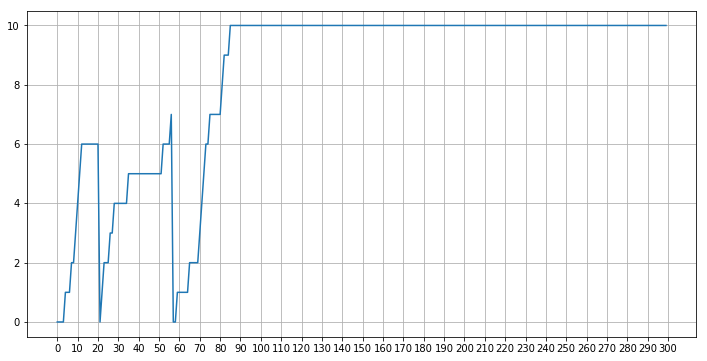

In [41]:
plt.figure(figsize=(12,6))
plt.plot(sys.machine_data[['M{} health'.format(m) for m in range(1)]])
plt.xticks(np.arange(0,301,10))
plt.grid()
plt.show()

In [38]:
sys.machine_data[['M{} health'.format(m) for m in range(3)]]

,M0 health,M1 health,M2 health
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,1.0,0.0
3,1.0,2.0,0.0
4,1.0,2.0,0.0
5,2.0,2.0,0.0
6,2.0,2.0,0.0
7,2.0,2.0,0.0
8,2.0,2.0,0.0
9,2.0,2.0,0.0
